# River Flood based on GloFAS Discharge Data

This tutorial will guide through the process of computing flood foodprints from GloFAS river discharge data and using these footprints in CLIMADA impact calculations.

Executing this tutorial requires access to the Copernicus Data Store (CDS) and the input data for the flood footprint pipeline.
Please have a look at the documentation of the [GloFAS River Flood module](../glofas_rf.rst) and follow the instructions in its "Preparation" section before continuing.

## Pipeline Configuration

The "data pipeline" downloads specific data from the Copernicus Data Store (CDS) and performs several tasks to compute flood footprints.
It is controlled via a configuration file.
For this tutorial, we use the adjusted configuration file `glofas_rf_historical.yml`.

The pipeline performs several operations:
1. Download historical discharge data for the countries Germany, Switzerland, and Austria of the year 2021.
2. Select a subset in time: July 2021.
3. Compute the equivalent return period from the discharge.
4. Interpolate the return period map in space onto the finer resolution of the flood maps.
5. Compute the flood depth from the interpolated return period. This yields the first result `flood_depth`.

The pipeline is executed with `climada_petals.hazard.rf_glofas.dantro_transform`, which returns a `dantro.DataManager`.
As defined in the pipeline, this manager contains the result `flood_depth`.
We can then create a hazard series from it.
As the respective data only contains three dimensions (longitude, latitude, and time), we can concatenate the events along the `time` dimension into a single ``Hazard`` object.
`climada_petals.hazard.rf_glofas.hazard_series_from_dataset` therefore returns a `pandas.Series` with only a single value, the ``Hazard`` object we want to retrieve (notice the `[0]`).

**Note:** The returned objects are `RiverFlood` objects with `haz_type="RF"`

In [1]:
from climada_petals.hazard.rf_glofas import dantro_transform, hazard_series_from_dataset

# Execute the pipeline and create a series from the data
# NOTE: This will take a while when executed for the first time, because the data first
#       has to be requested and downloaded. Grab a coffee, hang up the laundry or something!
data_manager = dantro_transform("glofas_rf_historical.yml")
hazards = hazard_series_from_dataset(
    data_manager["flood_depth"].data, event_dim="time"
)

# 'hazards' is a pd.Series with length 1
print(hazards)

# Retrieve the actual hazard object
flood = hazards[0]

INFO     data_mngr    Initializing ClimadaDataManager 'glofas-computation_Manager'...
HILIGHT  data_mngr    Loading 2 data entries ...
PROGRESS data_mngr    Loading data entry 'flood_maps' ...


  Loading  1/1  ...                                                             


PROGRESS data_mngr    Loaded all data for entry 'flood_maps' in 0.06s.

PROGRESS data_mngr    Loading data entry 'glofas_historical_gumbel_fit' ...


  Loading  1/1  ...                                                             


PROGRESS data_mngr    Loaded all data for entry 'glofas_historical_gumbel_fit' in 0.01s.

SUCCESS  data_mngr    Successfully loaded 2 data entries.
HILIGHT  plot_mngr    Performing plots from 1 plot configuration entry:
PROGRESS plot_mngr    Plotting 'with_cache' ...
INFO     base         Computing data transformation results ...



Tree of ClimadaDataManager 'glofas-computation_Manager', 2 members, 0 attributes
 └┬ flood_maps                  <XrDataContainer, float32, (return_period: 7, l…
  └ glofas_historical_gumbel_…  <PassthroughContainer, Dataset stored, 0 attrib…

  Loading  1/1  ...                                                             
  Loading  1/1  ...                                                             
  Loading  1/1  ...                                                             
  Loading  1/1  ...                                                             


INFO     base         Now calling plotting function 'finalize' ...
PROGRESS plot_mngr    Performed 'with_cache' plot in 0.5s.

SUCCESS  plot_mngr    Performed plots from 1 plot configuration in 0.5s.




Tree of ClimadaDataManager '64cda23c', 4 members, 0 attributes
 └┬ flood_maps                  <XrDataContainer, float32, (return_period: 7, l…
  ├ glofas_historical_gumbel_…  <PassthroughContainer, Dataset stored, 0 attrib…
  ├ cache                       <OrderedDataGroup, 1 member, 0 attributes>
    └─ dag                      <OrderedDataGroup, 4 members, 0 attributes>
       └┬ 79f8f43ca22a568d2b9…  <XrDataContainer, float32, (time: 365, latitude…
        ├ 5c86f46c3d3425bd8e8…  <XrDataContainer, float32, (time: 31, latitude:…
        ├ b2806ab4561cff23a36…  <XrDataContainer, float32, (time: 31, latitude:…
        └ 3f9de56e6efe01e9c2f…  <PassthroughContainer, Dataset stored, 0 attrib…
  └ flood_depth                 <PassthroughContainer, Dataset stored, 0 attrib…

2023-01-06 16:42:58,509 - climada.hazard.base - INFO - Loading Hazard from xarray Dataset
2023-01-06 16:42:58,575 - climada.hazard.base - DEBUG - Loading Hazard intensity from DataArray 'Flood Depth'
2023-01-06 16:42:

## Exposure and Vulnerability

When looking at flood warnings and protection we typically want to determine how many people might be affected from floods or lose their homes.
We therefore use data on population distribution as exposure.
To that end, we create a `LitPop` exposure with the `pop` mode for the countries of interest.

Being affected by a flood can be considered a binary classification (yes/no), therefore we use a simple step function with a relatively low threshold of 0.2 m.

Notice that we set the impact function identifier to `"RF"` because this is the hazard type identifier of `RiverFlood`.

In [2]:
from climada.entity import LitPop
from climada.entity import ImpactFunc
from climada.entity import ImpactFuncSet

# Create a population exposure
exposure = LitPop.from_countries(["Germany", "Switzerland", "Austria"], fin_mode="pop")
exposure.gdf["impf_RF"] = 1

# Create a impact function for being affected by flooding
impf_affected = ImpactFunc.from_step_impf(intensity=(0.0, 0.2, 100.0), impf_id=1)
impf_affected.haz_type = "RF"
impf_set_affected = ImpactFuncSet([impf_affected])

2023-01-06 16:43:00,390 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: DEU (276)...

2023-01-06 16:43:00,429 - climada.entity.exposures.litpop.nightlight - DEBUG - Found all required satellite data (1 files) in folder /Users/ldr.riedel/climada/data
2023-01-06 16:43:00,429 - climada.entity.exposures.litpop.nightlight - DEBUG - All required files already exist. No downloads necessary.
2023-01-06 16:43:00,469 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2023-01-06 16:43:00,469 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2023-01-06 16:43:00,474 - climada.entity.exposures.litpop.nightlight - DEBUG - Found all required satellite data (1 files) in folder /Users/ldr.riedel/climada/data
2023-01-06 16:43:00,475 - climada.entity.exposures.litpop.nightlight - DEBUG - All required files already exist. No downloads necessary.
2023-01-06 16:43:0

## Impact Calculation

We simply plug everything together and calculate the impact.
Afterwards, we plot the impact for 14 July 2021.

2023-01-06 16:43:35,126 - climada.entity.exposures.base - INFO - Matching 876313 exposures with 1529568 centroids.
2023-01-06 16:43:35,164 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-01-06 16:43:37,857 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 31 events.


<GeoAxesSubplot:>

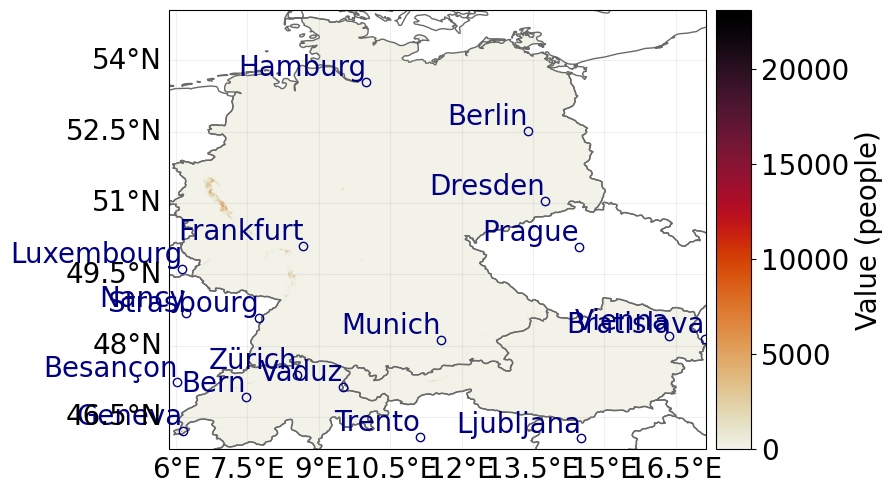

In [3]:
from climada.engine import ImpactCalc

imp_calc = ImpactCalc(exposure, impf_set_affected, flood)
imp = imp_calc.impact()
imp.plot_hexbin_impact_exposure(event_id=14)

## FLOPROS Database Protection Standards

So far, we ignored any protection standards, likely overestimating the impact of events.
The FLOPROS database provides information on river flood protection standards.
It is a supplement to the publication by [P. Scussolini et al.: "FLOPROS: an evolving global database of flood protection standards"](https://dx.doi.org/10.5194/nhess-16-1049-2016)

Download it here: https://dx.doi.org/10.5194/nhess-16-1049-2016-supplement

Unzip the downloaded file, and place the folder `FLOPROS_shp_V1/` into the `~/climada/data/glofas-computation/` folder.

The database is a shapefile that states the regional protection standard as event return period against which the respective region is protected.
The regions are modeled as (multi-)polygons.
The file can be read using GeoPandas.

We supply an additional configuration file `glofas_rf_historical_flopros.yml`, which loads the FLOPROS database and computes two flood footprints, one with and one without protection standards (the latter is the exact same as in the previous example).
We can run this new pipeline and compare the results for the two protection standards.
By default, we use the "Merged Layer" of the FLOPROS database.
Note however, that this data is found to generally *overestimate* protection standards, and thus the result might *underestimate* the impacts.

INFO     data_mngr    Initializing ClimadaDataManager 'glofas-computation_Manager'...
HILIGHT  data_mngr    Loading 3 data entries ...
PROGRESS data_mngr    Loading data entry 'flood_maps' ...


  Loading  1/1  ...                                                             


PROGRESS data_mngr    Loaded all data for entry 'flood_maps' in 0.02s.

PROGRESS data_mngr    Loading data entry 'glofas_historical_gumbel_fit' ...


  Loading  1/1  ...                                                             


PROGRESS data_mngr    Loaded all data for entry 'glofas_historical_gumbel_fit' in 0.01s.

PROGRESS data_mngr    Loading data entry 'flopros_database' ...


  Loading  1/1  ...                                                             


PROGRESS data_mngr    Loaded all data for entry 'flopros_database' in 0.51s.

SUCCESS  data_mngr    Successfully loaded 3 data entries.
HILIGHT  plot_mngr    Performing plots from 1 plot configuration entry:
PROGRESS plot_mngr    Plotting 'with_cache' ...
INFO     base         Computing data transformation results ...



Tree of ClimadaDataManager 'glofas-computation_Manager', 3 members, 0 attributes
 └┬ flood_maps                  <XrDataContainer, float32, (return_period: 7, l…
  ├ glofas_historical_gumbel_…  <PassthroughContainer, Dataset stored, 0 attrib…
  └ flopros_database            <PassthroughContainer, GeoDataFrame stored, 1 a…

  Loading  1/1  ...                                                             
  Loading  1/1  ...                                                             
  Loading  1/1  ...                                                             
  Loading  1/1  ...                                                             
  Loading  1/1  ...                                                             


INFO     base         Now calling plotting function 'finalize' ...
PROGRESS plot_mngr    Performed 'with_cache' plot in 0.3s.

SUCCESS  plot_mngr    Performed plots from 1 plot configuration in 0.3s.




Tree of ClimadaDataManager '64cda23c', 6 members, 0 attributes
 └┬ flood_maps                  <XrDataContainer, float32, (return_period: 7, l…
  ├ glofas_historical_gumbel_…  <PassthroughContainer, Dataset stored, 0 attrib…
  ├ flopros_database            <PassthroughContainer, GeoDataFrame stored, 1 a…
  ├ cache                       <OrderedDataGroup, 1 member, 0 attributes>
    └─ dag                      <OrderedDataGroup, 5 members, 0 attributes>
       └┬ 79f8f43ca22a568d2b9…  <XrDataContainer, float32, (time: 365, latitude…
        ├ 5c86f46c3d3425bd8e8…  <XrDataContainer, float32, (time: 31, latitude:…
        ├ b2806ab4561cff23a36…  <XrDataContainer, float32, (time: 31, latitude:…
        ├ 3f9de56e6efe01e9c2f…  <PassthroughContainer, Dataset stored, 0 attrib…
        └ d53ec34fa5d46cbf73c…  <PassthroughContainer, Dataset stored, 0 attrib…
  ├ flood_depth                 <PassthroughContainer, Dataset stored, 0 attrib…
  └ flood_depth_flopros         <PassthroughContainer, D

(0.0, 5763143.717967643)

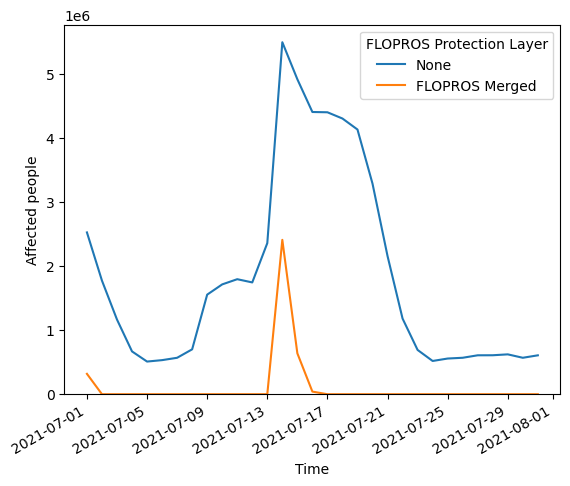

In [4]:
from datetime import date
import matplotlib.pyplot as plt

# Execute the new data pipeline
data_manager = dantro_transform("glofas_rf_historical_flopros.yml")
flood = hazard_series_from_dataset(
    data_manager["flood_depth"].data, event_dim="time"
)[0]
flood_flopros = hazard_series_from_dataset(
    data_manager["flood_depth_flopros"].data, event_dim="time"
)[0]

# Compute impacts for both results
imp_calc = ImpactCalc(exposure, impf_set_affected, flood)
imp = imp_calc.impact()
imp_calc = ImpactCalc(exposure, impf_set_affected, flood_flopros)
imp_flopros = imp_calc.impact()

# Plot the total impact
plt.plot([date.fromordinal(d) for d in flood.date], imp.at_event, label="None")
plt.plot([date.fromordinal(d) for d in flood_flopros.date], imp_flopros.at_event, label="FLOPROS Merged")
plt.legend(title="FLOPROS Protection Layer")
plt.xlabel("Time")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Affected people")
plt.ylim(bottom=0)

## Working with Forecasts

The `historical` data we have been working with so far is the re-analysis dataset.
Let us now have a look at the forecasts from the particular time period.
GloFAS offers single deterministic forecasts or ensemble forecasts of 51 ensemble members.

The configuration for downloading forecasts is supplied at `glofas_rf_forecast.yml`.
We will download the ensemble forecasts from 10 to 15 July 2021, with a lead time of 1 to 10 days each.
In the next operation `max_from_isel`, we will compute the maximum of the first three days and the maximum of the last 7 days.
From a warning perspective, the first time frame should be close enough that the ensemble does not diverge too strongly, and therefore the uncertainty for the forecasted impact will be relatively low.
The second time frame gives a more uncertain glimpse into the future.

Apart from the changes to `download_glofas_discharge` and the switch from `.sel` to `max_from_isel`, the operations are the same as in the last pipeline.

The resulting data now contains more dimensions than before:
Apart from longitude, latitude, and date (at which the forecast was issued), we now have the additional `number` (giving the number of the respective ensemble member) and `select` (from `max_from_isel`).
We therefore have to choose which dimension is to be considered the "event dimension" of the ``Hazard``.
Since we typically want to compute statistics over the forecast ensemble, it makes sense to concatenate over the `number` dimension, leaving `date` and `select` as dimensions for the `MultiIndex` of the hazard series.

In [5]:
# Execute the pipeline and create two series from the data
# NOTE: This will take a while when executed for the first time, because the data first
#       has to be requested and downloaded. Grab a coffee, hang up the laundry or something!
data_manager = dantro_transform("glofas_rf_forecast.yml")
hazards = hazard_series_from_dataset(
    data_manager["flood_depth"].data, event_dim="number"
)
hazards_flopros = hazard_series_from_dataset(
    data_manager["flood_depth_flopros"].data, event_dim="number"
)

print(hazards)

INFO     data_mngr    Initializing ClimadaDataManager 'glofas-computation_Manager'...
HILIGHT  data_mngr    Loading 3 data entries ...
PROGRESS data_mngr    Loading data entry 'flood_maps' ...


  Loading  1/1  ...                                                             


PROGRESS data_mngr    Loaded all data for entry 'flood_maps' in 0.02s.

PROGRESS data_mngr    Loading data entry 'glofas_historical_gumbel_fit' ...


  Loading  1/1  ...                                                             


PROGRESS data_mngr    Loaded all data for entry 'glofas_historical_gumbel_fit' in 0.01s.

PROGRESS data_mngr    Loading data entry 'flopros_database' ...


  Loading  1/1  ...                                                             


PROGRESS data_mngr    Loaded all data for entry 'flopros_database' in 0.51s.

SUCCESS  data_mngr    Successfully loaded 3 data entries.
HILIGHT  plot_mngr    Performing plots from 1 plot configuration entry:
PROGRESS plot_mngr    Plotting 'with_cache' ...
INFO     base         Computing data transformation results ...



Tree of ClimadaDataManager 'glofas-computation_Manager', 3 members, 0 attributes
 └┬ flood_maps                  <XrDataContainer, float32, (return_period: 7, l…
  ├ glofas_historical_gumbel_…  <PassthroughContainer, Dataset stored, 0 attrib…
  └ flopros_database            <PassthroughContainer, GeoDataFrame stored, 1 a…

  Loading  1/1  ...                                                             
  Loading  1/1  ...                                                             
  Loading  1/1  ...                                                             
  Loading  1/1  ...                                                             
  Loading  1/1  ...                                                             


INFO     base         Now calling plotting function 'finalize' ...
PROGRESS plot_mngr    Performed 'with_cache' plot in 0.3s.

SUCCESS  plot_mngr    Performed plots from 1 plot configuration in 0.3s.




Tree of ClimadaDataManager '64cda23c', 6 members, 0 attributes
 └┬ flood_maps                  <XrDataContainer, float32, (return_period: 7, l…
  ├ glofas_historical_gumbel_…  <PassthroughContainer, Dataset stored, 0 attrib…
  ├ flopros_database            <PassthroughContainer, GeoDataFrame stored, 1 a…
  ├ cache                       <OrderedDataGroup, 1 member, 0 attributes>
    └─ dag                      <OrderedDataGroup, 5 members, 0 attributes>
       └┬ a52b75bb55cd6e2a336…  <XrDataContainer, float32, (time: 6, number: 50…
        ├ b9cddf2ba4e6d6adfd3…  <XrDataContainer, float32, (select: 2, time: 6,…
        ├ 1e99316d2bd736517f8…  <XrDataContainer, float32, (select: 2, time: 6,…
        ├ f9233697fda5081faac…  <PassthroughContainer, Dataset stored, 0 attrib…
        └ 045be320cc847cc903d…  <PassthroughContainer, Dataset stored, 0 attrib…
  ├ flood_depth                 <PassthroughContainer, Dataset stored, 0 attrib…
  └ flood_depth_flopros         <PassthroughContainer, D

2023-01-06 16:59:04,271 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2023-01-06 16:59:04,275 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2023-01-06 16:59:04,277 - climada.entity.exposures.base - INFO - Matching 876313 exposures with 1529568 centroids.
2023-01-06 16:59:04,448 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-01-06 16:59:07,639 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.
2023-01-06 16:59:07,933 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.
2023-01-06 16:59:08,159 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.
2023-01-06 16:59:08,309 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.
2023-01-06 

Text(0.5, 1.0, 'Potentially Affected People over next 3 Days')

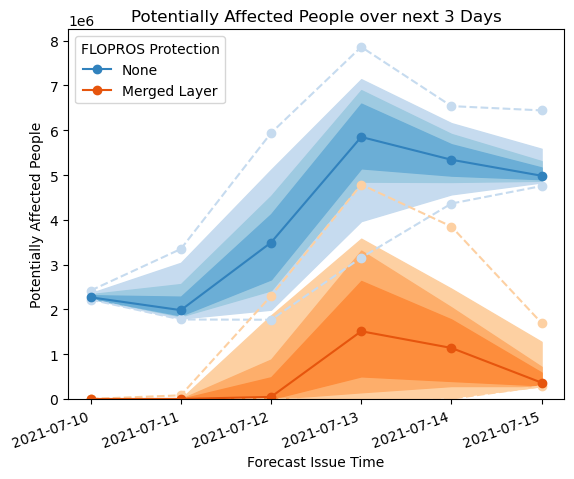

In [7]:
import numpy as np
import pandas as pd

# Hazards all have the same coordinates
exposure.assign_centroids(hazards.iat[0])


def compute_at_event(hazard):
    """Compute the impact of a hazard and return 'at_event'"""
    imp_calc = ImpactCalc(exposure, impf_set_affected, hazard)
    imp = imp_calc.impact(save_mat=False, assign_centroids=False)
    return imp.at_event.copy()


def get_at_event_time_series(df, select):
    """Return a time series of 'at_event' quantiles for a data frame and select level"""
    df_subset = df.xs(select, level="select")
    at_event = df_subset["at_event"].to_numpy()
    at_event = np.vstack([arr for arr in at_event])
    median = np.median(at_event, axis=1)
    minimum = np.nanmin(at_event, axis=1)
    maximum = np.nanmax(at_event, axis=1)
    quantiles = [0.05, 0.95, 0.15, 0.85, 0.25, 0.75]
    quant = np.quantile(at_event, quantiles, axis=1)

    return dict(
        time=df_subset.index,
        median=median,
        minimum=minimum,
        maximum=maximum,
        quantile_50=(quant[4], quant[5]),
        quantile_70=(quant[2], quant[3]),
        quantile_90=(quant[0], quant[1]),
    )


def plot_result(result, color_cycle: int, label):
    """Plot the result from 'get_at_event_time_series'"""
    colors = plt.get_cmap("tab20c").colors[0 + 4 * color_cycle : 5 + 4 * color_cycle]
    plt.plot(result["time"], result["minimum"], "o--", color=colors[3])
    plt.plot(result["time"], result["maximum"], "o--", color=colors[3])
    plt.plot(result["time"], result["median"], "o-", color=colors[0], label=label)
    plt.fill_between(
        result["time"],
        result["quantile_90"][0],
        result["quantile_90"][1],
        color=colors[3],
    )
    plt.fill_between(
        result["time"],
        result["quantile_70"][0],
        result["quantile_70"][1],
        color=colors[2],
    )
    plt.fill_between(
        result["time"],
        result["quantile_50"][0],
        result["quantile_50"][1],
        color=colors[1],
    )


def compute_and_plot(hazard_series, select, color_cycle, label):
    """Compute impacts, evaluate them, and plot the result"""
    df = pd.DataFrame({"hazard": hazard_series}, index=hazard_series.index)
    df["at_event"] = [compute_at_event(haz) for haz in df["hazard"]]
    plot_result(
        get_at_event_time_series(df, select=select),
        color_cycle=color_cycle,
        label=label,
    )


compute_and_plot(hazards, select=0, color_cycle=0, label="None")
compute_and_plot(hazards_flopros, select=0, color_cycle=1, label="Merged Layer")

plt.legend(title="FLOPROS Protection")
plt.ylim(bottom=0)
plt.ylabel("Potentially Affected People")
plt.xlabel("Forecast Issue Time")
plt.xticks(rotation=20, ha="right")
plt.title("Potentially Affected People over next 3 Days")


2023-01-06 16:59:32,831 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.
2023-01-06 16:59:33,091 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.
2023-01-06 16:59:33,218 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.
2023-01-06 16:59:33,396 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.
2023-01-06 16:59:33,572 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.
2023-01-06 16:59:33,706 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.
2023-01-06 16:59:33,835 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.
2023-01-06 16:59:33,960 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.
2023-01-06 16:59:34,089 - climada.engine

Text(0.5, 1.0, 'Potentially Affected People in next 3 to 10 Days')

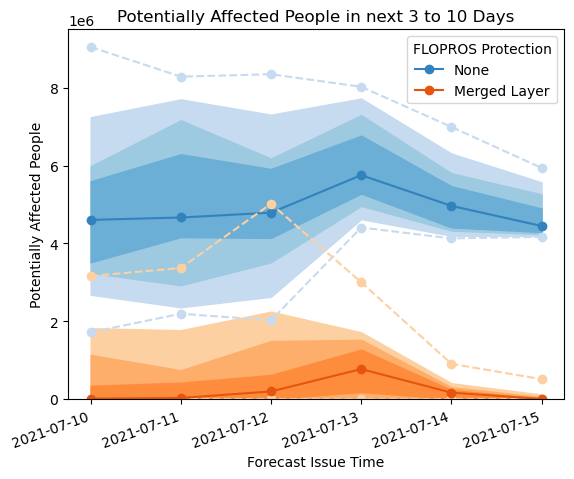

In [8]:
compute_and_plot(hazards, select=1, color_cycle=0, label="None")
compute_and_plot(hazards_flopros, select=1, color_cycle=1, label="Merged Layer")

plt.legend(title="FLOPROS Protection")
plt.ylim(bottom=0)
plt.ylabel("Potentially Affected People")
plt.xlabel("Forecast Issue Time")
plt.xticks(rotation=20, ha="right")
plt.title("Potentially Affected People in next 3 to 10 Days")